<a href="https://colab.research.google.com/github/m-hironori/learing-keras/blob/master/1_%E3%83%A2%E3%83%87%E3%83%AB%E4%BD%9C%E6%88%90%E3%81%AE%E5%9F%BA%E6%9C%AC(MNIST%E3%83%87%E3%83%BC%E3%82%BF%E3%81%A7%E6%89%8B%E6%9B%B8%E3%81%8D%E6%96%87%E5%AD%97%E8%AA%8D%E8%AD%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

# モデル作成の基本(MNISTデータで手書き文字認識)



kerasによるモデル作成の基本として、MNIST手書き文字認識を解いてみましょう。



 

## 問題設定

まずは、問題設定を確認してみましょう。


問題属性 | 問題内容
--- | ---
入力データ形式 | 手書きの数字 ( 0 - 9 ) 画像。28 * 28 の白黒。70,000 枚。
予測すること | 0 - 9 のどれが書いてあるか。多クラス分類問題。 
評価指標 | accuracy
評価方法 | ホールドアウト(訓練 60,000, テスト 10,000)

0 から 9 の手書き数字画像を入力に、何の数字かを当てることです。

この問題は、データセットが用意されていること、
データセットのサイズ小さいこと、
DeppLearningの内容説明のしやすさもあり、
非常によく取り上げられるます。

## データ準備



データの準備をしてみましょう。

In [0]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

keras には、あらかじめ MNIST データを準備する関数が用意されているので、これだけで、データを取ってこれます。

`mnist.loaddata()` 関数は、データを特定のURLからダウンロードし、`.keras`フォルダにおき、numpy行列としてロードしています。データがすでにフォルダにある場合はダウンロードしないようになっています。

* データはテンソル ( Numpy でーたが扱いやすい ) として準備
* 値は [ -1 , -1 ] や [ 0 , 1 ] ぐらいの値にスケーリングしておく
* 特徴量の値の範囲がことなったり、異なる種類のデータを使う場合は、スケールを合わせるためにデータを正規化する 



データの準備では、手元にデータを取ってきたら、ニューラルネットワークに合うように整形しておきましょう。特に値が全く異なる範囲の場合は、正規化しておきましょう。あらかじめ値の正規化したり、正規化の仕組みをニューラルネットワーク内に組み込んでおくこともできます。

先ほどとってきたMNISTのデータ内容を見てみましょう。

In [3]:
print("\tデータ型")
print(f"訓練データ\t{type(train_images)}")
print(f"訓練ラベル\t{type(train_labels)}")
print(f"テストデータ\t{type(test_images)}")
print(f"テストラベル\t{type(test_labels)}")

	データ型
訓練データ	<class 'numpy.ndarray'>
訓練ラベル	<class 'numpy.ndarray'>
テストデータ	<class 'numpy.ndarray'>
テストラベル	<class 'numpy.ndarray'>


ロードしたデータは、すでにNumpy形式になっていますね。データ型変換はしなくてもよさそうです。

In [4]:
import numpy as np

print("\tデータサイズ\t型\t最大値\t最小値")
print(f"訓練データ\t{train_images.shape}\t{train_images.dtype}\t{train_images.max()}\t{train_images.min()}")
print(f"訓練ラベル\t{train_labels.shape}\t{train_labels.dtype}\t{train_labels.max()}\t{train_labels.min()}")
print(f"テストデータ\t{test_images.shape}\t{test_images.dtype}\t{test_images.max()}\t{test_images.min()}")
print(f"テストラベル\t{test_labels.shape}\t{test_labels.dtype}\t{test_labels.max()}\t{test_labels.min()}")

	データサイズ	型	最大値	最小値
訓練データ	(60000, 28, 28)	uint8	255	0
訓練ラベル	(60000,)	uint8	9	0
テストデータ	(10000, 28, 28)	uint8	255	0
テストラベル	(10000,)	uint8	9	0


訓練データは 60000 枚の 縦 28 × 横 28 の画像、各値は整数値、最大値 255, 最小値 0です。
訓練ラベルは、60000個の正解データで整数値、最大値 9, 最小値 0です。テストデータとテストラベルは、10000 枚で、同じ形式の画像とラベルです。

データは、白黒画像で255諧調の画像ですね。ラベルは、手書き文字のの正解の数字の 0 - 9 ですね。

ここからわかることは、データは、0 - 1 にスケーリングして、入力したほうがよさそうです。
ラベルは、one-hot encoding しておいたほうがよさそうです。

次は、データの中身を一つ取り出して見てみましょう。

訓練ラベル	5


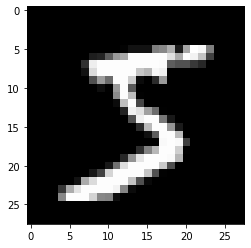

In [5]:
print(f"訓練ラベル\t{train_labels[0]}")
import matplotlib.pyplot as plt

plt.imshow(train_images[0], cmap='gray')

数字 5 の手書き数字画像であることがわかります。

## ベースライン精度(統計的検出力)

データの統計的な情報から、ランダムに選択した場合の精度を求めてみます。
これから作成するモデルで、これを上回らないと、ランダムに選択したときに負けてしまい、意味がなくなります。

Text(0.5, 1.0, 'test_labels histgram')

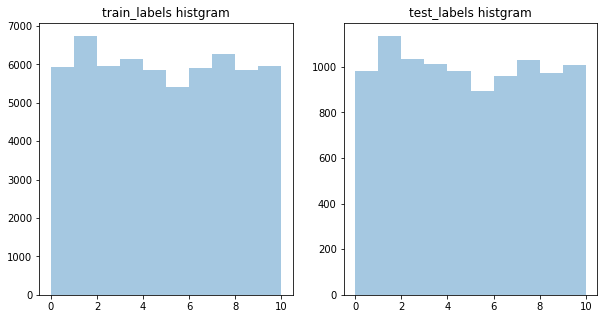

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
import seaborn as sns
sns.distplot(train_labels, kde=False, rug=False, bins=range(11), ax=ax1)
ax1.set_title("train_labels histgram")
sns.distplot(test_labels, kde=False, rug=False, bins=range(11), ax=ax2) 
ax2.set_title("test_labels histgram")

評価指標 | 統計的検出力
--- | ---
accuracy | 0.1

各数字とも大体同程度含んでいて、訓練データもテストデータもほぼ分布です。

したがって、accuracy = 0.1 が統計的検出力となります。 

## モデル開発

では、モデルを開発してみましょう。

### モデルを定義する

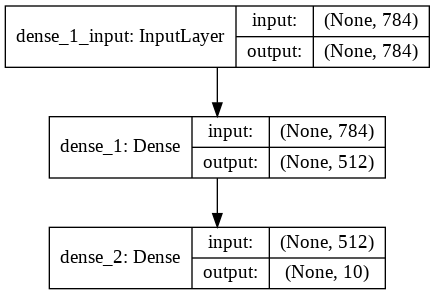

In [7]:
from keras import models
from keras import layers
from keras.utils import plot_model

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

plot_model(network, show_shapes=True)

このように、あらかじめ定義された層を、重ねていくだけで、DeepLearningのモデルが出来上がってしまいます。

今回は、非常に簡単なモデルです。

入力は、縦横 28 × 28 の画像のそれぞれの画素を横に並べたものを想定しています。ですので、全部で 784 個の値が入力になっています。

初めは、Denseレイヤーです。ここでは、512個の要素に変換し、活性化関数はReLUです。

最後の、Denseレイヤーは、出力となる 0 から 9 の10個のどれかの分類問題と解くため、10個の要素に変換し、活性化関数はSoftMAXです。



### コンパイルする

In [8]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

次に、このネットワークをコンパイルします。コンパイルにより、損失関数と最適化方法を指定します。

今回は、損失関数をCategory CrossEntropy、最適化手法をRmsPropを指定します。

### データを整形する

In [0]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

先ほどのデータ準備で分かった必要な変換と、今回のモデル定義に従った変換を行います。

画像データは、正規化のため、255で割っています。また、モデル定義で、各画素を直列に並べたデータを入力にするため、画像をフラットに変換しています。

ラベルは、onehot encoding しています。

### 訓練する

In [13]:
np.random.seed(seed=0)
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)
train_images = train_images[indices]
train_labels = train_labels[indices]

history = network.fit(train_images, train_labels, epochs=12, batch_size=128, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/12
54000/54000 [==============================] - 5s 89us/step - loss: 0.0138 - acc: 0.9965 - val_loss: 0.0153 - val_acc: 0.9955
Epoch 2/12
54000/54000 [==============================] - 5s 85us/step - loss: 0.0091 - acc: 0.9976 - val_loss: 0.0262 - val_acc: 0.9913
Epoch 3/12
54000/54000 [==============================] - 5s 87us/step - loss: 0.0074 - acc: 0.9982 - val_loss: 0.0141 - val_acc: 0.9967
Epoch 4/12
54000/54000 [==============================] - 5s 86us/step - loss: 0.0054 - acc: 0.9988 - val_loss: 0.0196 - val_acc: 0.9948
Epoch 5/12
54000/54000 [==============================] - 5s 88us/step - loss: 0.0046 - acc: 0.9991 - val_loss: 0.0144 - val_acc: 0.9953
Epoch 6/12
54000/54000 [==============================] - 5s 89us/step - loss: 0.0037 - acc: 0.9991 - val_loss: 0.0211 - val_acc: 0.9935
Epoch 7/12
54000/54000 [==============================] - 5s 85us/step - loss: 0.0032 - acc: 0.9993 - val_loss: 0.0184 - val_acc:

訓練には、fitメソッドを呼ぶだけです。

今回は、10% をvalidationデータとして指定しています。

ここで、注意が必要なのは、validation_splitを指定した場合、validationデータは、ランダムに選ばれるわけではなく、最後の10%が選ばれるということです。なので、今回は、訓練データをあらかじめランダムに並べ替えておきました。

### 精度を測る

In [11]:
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)


10000/10000 [==============================] - 1s 54us/step
test_acc: 0.9812


0.98 近くの精度が出ました。非常に良い結果でした。

先のベースラインは 0.1 でしたので、大きく超えました。

### 学習過程を見てみる

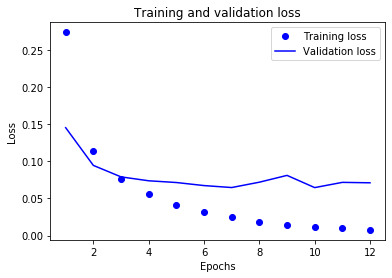

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

訓練データの loss は順調に下がっているのがわかります。しかし、validationデータの loss は 7 エポック以降下がらず、のちに上がっているのがわかります。

つまり、7 エポック以降は過学習を起こしています。

各種パラメタの調整により、過学習を抑えた学習を行うことが必要かもしれません。
初手は、最適化関数の学習率を低くすることでしょう。
または、Denseの要素数を減らすと安定するかもしれません。

そもそも、安定したとしても、これ以上の精度を求めるのが難しいかもしれません。
モデルそのものを変更すべきでしょう。

## まとめ

* 機械学習の大まかなフローに沿って、最も一般的なMNIST手書き文字認識を解いた
  * 問題設定 → データ準備 → ベースライン精度算出 → モデル開発
* データ準備では、データの内容を確認することで、モデル開発時のデータ変換方法を確認
* モデル開発では、kerasを利用して、非常に簡単なDenseレイヤーのみのモデルを開発
  * あらかじめ用意されているレイヤを積み重ねるだけで、Deep Learnig のモデルができる
  * fitメソッドや、evaluateメソッドを呼ぶだけで、学習や評価ができてしまう
  * 簡単なモデルなのに、精度は90%を超える

今回は、機械学習エンジニアリングやデータサイエンティストが行うフローに従って、MNIST手書き文字認識問題を解いてみました。

データ準備で、データ内容を確認し、モデル開発での変換をスムーズに行うことができます。

モデル開発では、Kerasを使って、2層の非常に簡単なモデルを作成しました。

あらかじめ定義されたレイヤを積み重ねるだけでモデルができてしまいました。

今回は非常に単純なモデルで、画像処理でよく用いるConvolusion手法などは全く利用していません。それでも、90%近くの精度を確保できることがわかりました。


